In [1]:
import tensorflow as tf
import numpy as np 
import tqdm
import pandas as pd 
import matplotlib 
from matplotlib import pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### No Batch-Norm

In [8]:
n_steps = 100
batch_size = 60

n_inputs = 784
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

w1_initial = np.random.normal(size=(n_inputs, n_hidden1))
w2_initial = np.random.normal(size=(n_hidden1, n_hidden2))
w3_initial = np.random.normal(size=(n_hidden2, n_outputs))

X = tf.placeholder(tf.float32, shape=[None, n_inputs], name='X')
Y = tf.placeholder(tf.float32, shape=[None, n_outputs], name='Y')

w1 = tf.Variable(w1_initial, dtype=tf.float32, name='w1')
b1 = tf.Variable(tf.ones([n_hidden1]), name='b1')
z1 = tf.matmul(X, w1, name='z1') + b1
o1 = tf.nn.sigmoid(z1)

w2 = tf.Variable(w2_initial, dtype=tf.float32, name='w2')
b2 = tf.Variable(tf.ones([n_hidden2]), name='b2')
z2 = tf.matmul(o1, w2, name='z2') + b2
o2 = tf.nn.sigmoid(z2)

w3 = tf.Variable(w3_initial, dtype=tf.float32, name='w3')
b3 = tf.Variable(tf.ones([n_outputs]), name='b3')
z3 = tf.matmul(o2, w3, name='z3') + b3

y_pred = tf.nn.softmax(z3, axis=1)

cross_entropy_loss = -tf.reduce_sum(Y * tf.log(y_pred))
cross_entropy_loss_summary  = tf.summary.scalar(name='cross_entropy_loss', tensor=cross_entropy_loss)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.03).minimize(cross_entropy_loss)

correct_predictions = tf.equal(tf.argmax(Y, axis=1), tf.argmax(y_pred, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

accs = []
losses = []
with tf.Session() as sess:
    writer = tf.summary.FileWriter('./batch-normalization/graph')
    sess.run(tf.global_variables_initializer())
    for epoch in tqdm.tqdm(range(n_steps)):
        for i in range(0, mnist.train.images.shape[0], batch_size):
            x, y = mnist.train.images[i:i+batch_size], mnist.train.labels[i:i+batch_size]
            sess.run(optimizer, {X : x, Y : y})
        #if epoch % 50 == 0:
            res = sess.run([accuracy, cross_entropy_loss, cross_entropy_loss_summary], {X : mnist.test.images, Y : mnist.test.labels})
            losses.append(res[1])
            #writer.add_summary(res[2], epoch)

100%|██████████| 100/100 [14:07<00:00,  8.39s/it]


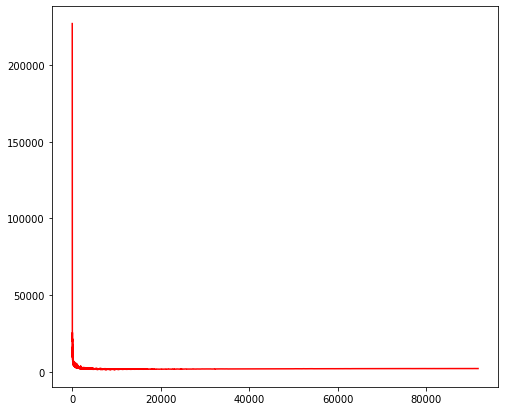

In [9]:
plt.figure(figsize=(8, 7))
plt.plot(range(len(losses)), losses, c='r')
plt.show()

### Batch-Norm

In [23]:
epsilon = 1e-3

X = tf.placeholder(tf.float32, shape=[None, n_inputs], name='X')
Y = tf.placeholder(tf.float32, shape=[None, n_outputs], name='Y')

#layer 1
w1 = tf.Variable(w1_initial, dtype=tf.float32, name='w1')
b1 = tf.Variable(tf.ones([n_hidden1]), dtype=tf.float32, name='b1')
z1 = tf.matmul(X, w1) + b1

batch_mean1, batch_var1 = tf.nn.moments(z1, [0])
batch_normalized_z1 = (z1 - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
scale1 = tf.Variable(tf.ones([n_hidden1]), dtype=tf.float32)
beta1 = tf.Variable(tf.zeros([n_hidden1]), dtype=tf.float32)

scaled_shifted_z1 = scale1 * batch_normalized_z1 + beta1
o1 = tf.nn.sigmoid(scaled_shifted_z1)

#layer2
w2 = tf.Variable(w2_initial, dtype=tf.float32, name='w2')
b2 = tf.Variable(tf.ones([n_hidden2]), dtype=tf.float32, name='b2')
z2 = tf.matmul(o1, w2) + b2

batch_mean2, batch_var2 = tf.nn.moments(z2, [0])
batch_normalized_z2 = (z2 - batch_mean2) / tf.sqrt(batch_var2 + epsilon)
scale2 = tf.Variable(tf.ones([n_hidden2]), dtype=tf.float32)
beta2 = tf.Variable(tf.zeros([n_hidden2]), dtype=tf.float32)

scaled_shifted_z2 = scale2 * batch_normalized_z2 + beta2
o2 = tf.nn.sigmoid(scaled_shifted_z2)

#layer3 
w3 = tf.Variable(w3_initial, dtype=tf.float32, name='w3')
b3 = tf.Variable(tf.ones([n_outputs]), dtype=tf.float32, name='b3')
z3 = tf.matmul(o2, w3) + b3

y_pred = tf.nn.softmax(z3)

